In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("cleaned_data.csv")

In [ ]:
print(df.shape)
df = pd.get_dummies(data=df, columns=['Platform', 'Genre', 'Rating'])
print(df.shape)
df.head

(16445, 16)
(16445, 65)


<bound method NDFrame.head of                                 Name  Year_of_Release     Publisher  NA_Sales  \
0                         Wii Sports             2006      Nintendo     41.36   
1                  Super Mario Bros.             1985      Nintendo     29.08   
2                     Mario Kart Wii             2008      Nintendo     15.68   
3                  Wii Sports Resort             2009      Nintendo     15.61   
4           Pokemon Red/Pokemon Blue             1996      Nintendo     11.27   
...                              ...              ...           ...       ...   
16440  Samurai Warriors: Sanada Maru             2016    Tecmo Koei      0.00   
16441               LMA Manager 2007             2006   Codemasters      0.00   
16442        Haitaka no Psychedelica             2016  Idea Factory      0.00   
16443               Spirits & Spells             2003       Wanadoo      0.01   
16444            Winning Post 8 2016             2016    Tecmo Koei      0.00   

       EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0         28.96      3.77         8.45         82.53          76.0   
1          3.58      6.81         0.77         40.24          69.5   
2         12.76      3.79         3.29         35.52          82.0   
3         10.93      3.28         2.95         32.77          80.0   
4          8.89     10.22         1.00         31.37          74.0   
...         ...       ...          ...           ...           ...   
16440      0.00      0.01         0.00          0.01          68.0   
16441      0.01      0.00         0.00          0.01          75.0   
16442      0.00      0.01         0.00          0.01          66.0   
16443      0.00      0.00         0.00          0.01          69.5   
16444      0.00      0.01         0.00          0.01          70.0   

       Critic_Count  ...  Genre_Strategy  Rating_AO Rating_E  Rating_E10+  \
0              51.0  ...           False      False     True        False   
1               0.0  ...           False      False    False        False   
2              73.0  ...           False      False     True        False   
3              73.0  ...           False      False     True        False   
4               0.0  ...           False      False    False        False   
...             ...  ...             ...        ...      ...          ...   
16440           0.0  ...           False      False    False        False   
16441           0.0  ...           False      False    False        False   
16442           0.0  ...           False      False    False        False   
16443           0.0  ...           False      False    False        False   
16444           0.0  ...           False      False    False        False   

       Rating_EC  Rating_K-A  Rating_M  Rating_RP  Rating_T  Rating_Unknown  
0          False       False     False      False     False           False  
1          False       False     False      False     False            True  
2          False       False     False      False     False           False  
3          False       False     False      False     False           False  
4          False       False     False      False     False            True  
...          ...         ...       ...        ...       ...             ...  
16440      False       False     False      False     False            True  
16441      False       False     False      False     False            True  
16442      False       False     False      False     False            True  
16443      False       False     False      False     False            True  
16444      False       False     False      False     False            True  

[16445 rows x 65 columns]>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder

df = pd.read_csv("cleaned_data.csv")
df = df.dropna(subset=["Global_Sales"])

te = TargetEncoder(cols=['Publisher','Developer'])
df[['Publisher','Developer']] = te.fit_transform(df[['Publisher','Developer']], df['Global_Sales'])


df = pd.get_dummies(df,
                    columns=['Platform','Genre','Rating'],
                    drop_first=True)


X = df.drop(columns=["Global_Sales","Name",
                     "NA_Sales","EU_Sales","JP_Sales","Other_Sales"])
df['Global_Sales'] = df['Global_Sales'].clip(upper=20)
y = np.log1p(df['Global_Sales'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


MAE: 0.1555, RMSE: 0.2560, R2: 0.5963


<ipython-input-13-3316f26fc67e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x="Importance", y="Feature", palette="viridis")


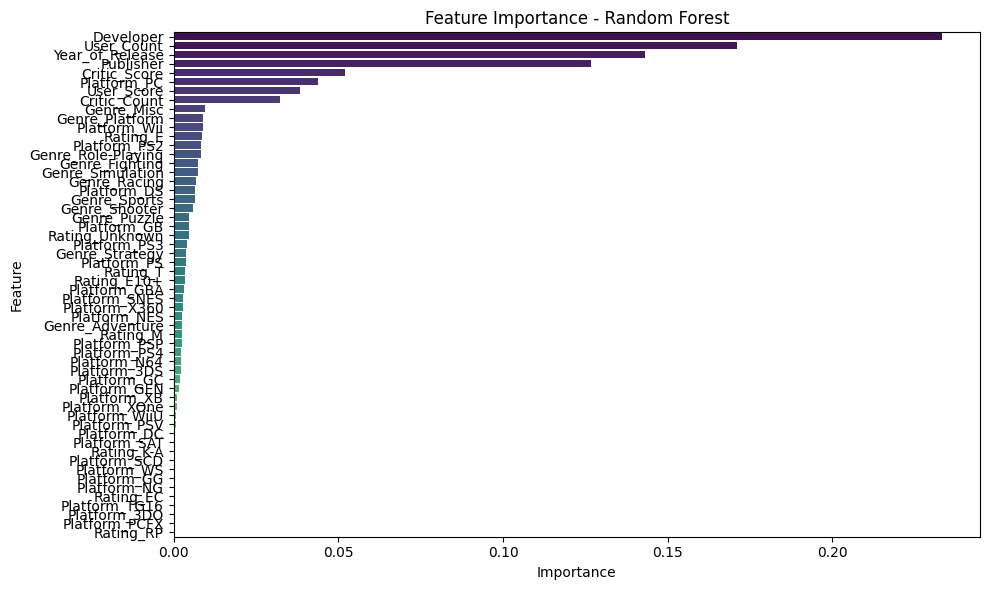

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X_train.columns

feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

r_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                              param_distributions=param_dist,
                              n_iter=20, cv=3, n_jobs=-1, verbose=1)
r_search.fit(X_train, y_train)

print("Best Params:", r_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


In [ ]:

best_model = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=None,
    bootstrap=True,
    random_state=42
)

best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")


MAE: 0.1524
RMSE: 0.2509
R2: 0.6120


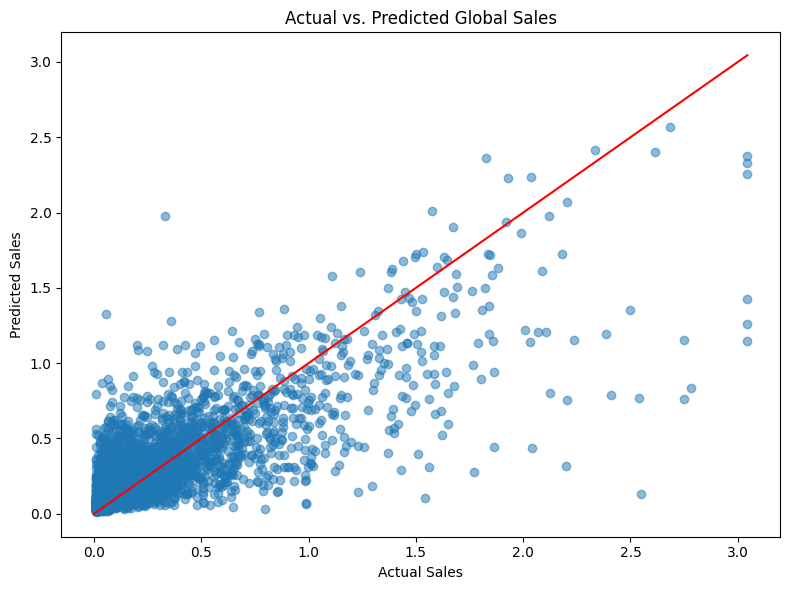

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Global Sales")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red')
plt.tight_layout()
plt.show()


In [ ]:
#Parameter grid for Gradient Boosting Regressor
param_grid_gbr = [
    {'n_estimators': [200, 225, 250, 275], 'max_features': [6, 8, 10, 12], 'max_depth': [5, 7, 9]}
]


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

grid_search_gbr = GridSearchCV(GradientBoostingRegressor(), param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search_gbr.best_params_))
gbr_best_cross_val_score = (np.sqrt(-grid_search_gbr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(gbr_best_cross_val_score)))
gbr_score = np.sqrt(-grid_search_gbr.score(X_test, y_test))
print("Test set score: {:.2f}".format(np.expm1(gbr_score)))

Best parameters: {'max_depth': 7, 'max_features': 12, 'n_estimators': 225}
Best cross-validation score: 0.28
Test set score: 0.28


In [ ]:

Y_test_pred = grid_search_gbr.best_estimator_.predict(X_test)

# R² Score
r2_test = r2_score(y_test, Y_test_pred)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, Y_test_pred))

# MAE
mae_test = mean_absolute_error(y_test, Y_test_pred)

print("Test R²: {:.4f}".format(r2_test))
print("Test RMSE: {:.4f}".format(rmse_test))
print("Test MAE: {:.4f}".format(mae_test))


Test R²: 0.6234
Test RMSE: 0.2472
Test MAE: 0.1512


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

models = {
    "Random Forest": RandomForestRegressor(**r_search.best_params_, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(**grid_search_gbr.best_params_),
    "XGBoost": XGBRegressor(n_estimators=100, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=100)
}

print("Model Comparison:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"{name} ➤ R2: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")


Model Comparison:

Random Forest ➤ R2: 0.6120 | RMSE: 0.2509 | MAE: 0.1524
Gradient Boosting ➤ R2: 0.6307 | RMSE: 0.2448 | MAE: 0.1501
XGBoost ➤ R2: 0.6154 | RMSE: 0.2498 | MAE: 0.1528
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 13156, number of used features: 46
[LightGBM] [Info] Start training from score 0.304298
LightGBM ➤ R2: 0.6228 | RMSE: 0.2474 | MAE: 0.1528


Gradient Boosting – highest R² and lowest RMSE
 Gradient Boosting edges out overall in performance and generalization.



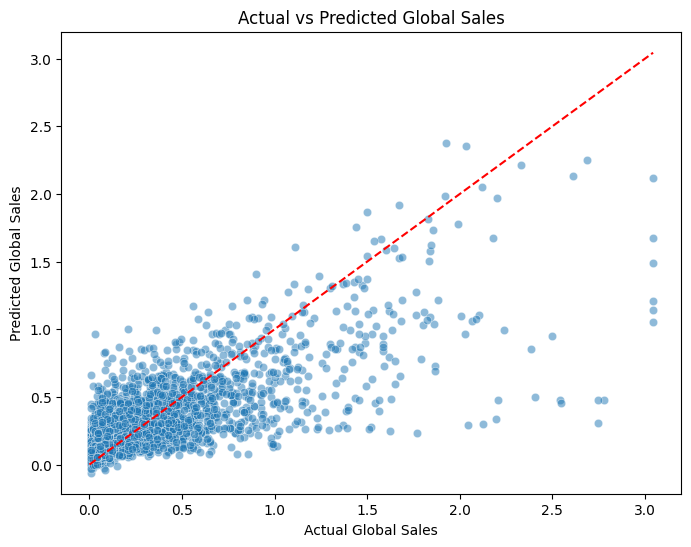

In [ ]:
best_model = GradientBoostingRegressor(n_estimators=100)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')  # perfect line
plt.xlabel("Actual Global Sales")
plt.ylabel("Predicted Global Sales")
plt.title("Actual vs Predicted Global Sales")
plt.show()
